In [17]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve
import xgboost as xgb
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv(r"C:\Users\alefs\OneDrive\Documentos\LAPEI-CIGETS\GitHub\tcp\01_dados\data_mobilidade_v4.csv")

list(df)

['Unnamed: 0',
 'id',
 'id_seq',
 'transicao',
 'V1023',
 'idade',
 'genero',
 'VD3004',
 'V2010',
 'V2005',
 'UF',
 'qtd_pessoas',
 'periodo_ajust',
 'ensino_medio',
 'ensino_superior',
 'raça',
 'posicao_familiar',
 'tempo_desemprego',
 'filhos',
 'regiao',
 'renda_domiciliar',
 'renda_depois']

In [26]:
df_tratado = df.rename(columns={'V1023':'regiao_urbana','VD3004':'escolaridade','V2010':'cor','UF':'uf'})

df_tratado = df_tratado[['transicao','regiao_urbana','idade','escolaridade', 'genero', 'cor','qtd_pessoas',
                         'periodo_ajust','posicao_familiar', 'tempo_desemprego','renda_domiciliar',
                        'filhos', 'uf']]

bins = [0, 3, 5, 9, 21, float('inf')]
labels = ['Tempo de desemprego: muito baixo', 'Tempo de desemprego: baixo', 
          'Tempo de desemprego: mediano', 'Tempo de desemprego: alto', 'Tempo de desemprego: muito alto']
df_tratado['intervalo_desemprego'] = pd.cut(df_tratado['tempo_desemprego'], bins=bins, labels=labels, right=False)

df_tratado['transicao'] = df_tratado['transicao'].map({'Migrou para TCP': 1, 'Migrou para o setor privado': 0})

df_tratado = df_tratado.drop(columns = 'tempo_desemprego')

df_final = df_tratado[df_tratado['periodo_ajust'] == 'Pós-pandemia']

df_final.head(30).style

,transicao,regiao_urbana,idade,escolaridade,genero,cor,qtd_pessoas,periodo_ajust,posicao_familiar,renda_domiciliar,filhos,uf,intervalo_desemprego
3870,0,Capital,29,Médio completo ou equivalente,Homem,Parda,3.800000,Pós-pandemia,Responsável pelo domicílio,362.500000,1,Amazonas,Tempo de desemprego: mediano
3871,0,"Resto da UF (Unidade da Federação, excluindo a região metropolitana e a RIDE)",56,Fundamental incompleto ou equivalente,Homem,Parda,2.000000,Pós-pandemia,Responsável pelo domicílio,0.000000,1,Amazonas,Tempo de desemprego: baixo
3875,0,"Resto da UF (Unidade da Federação, excluindo a região metropolitana e a RIDE)",23,Superior completo,Homem,Parda,1.000000,Pós-pandemia,Responsável pelo domicílio,0.000000,0,Pará,Tempo de desemprego: muito baixo
3878,1,Capital,26,Médio completo ou equivalente,Homem,Branca,2.000000,Pós-pandemia,Responsável pelo domicílio,628.500000,0,Amapá,Tempo de desemprego: muito baixo
3882,0,"Resto da UF (Unidade da Federação, excluindo a região metropolitana e a RIDE)",19,Médio incompleto ou equivalente,Homem,Parda,4.000000,Pós-pandemia,Não responsável pelo domicílio,237.500000,0,Maranhão,Tempo de desemprego: baixo
3883,1,"Resto da UF (Unidade da Federação, excluindo a região metropolitana e a RIDE)",29,Superior completo,Homem,Parda,2.400000,Pós-pandemia,Não responsável pelo domicílio,200.000000,0,Maranhão,Tempo de desemprego: alto
3884,1,Capital,23,Superior completo,Mulher,Parda,4.000000,Pós-pandemia,Não responsável pelo domicílio,3503.500000,0,Piauí,Tempo de desemprego: muito baixo
3885,0,Capital,23,Médio completo ou equivalente,Mulher,Preta,3.600000,Pós-pandemia,Não responsável pelo domicílio,314.250000,0,Piauí,Tempo de desemprego: baixo
3886,1,"Resto da UF (Unidade da Federação, excluindo a região metropolitana e a RIDE)",36,Médio incompleto ou equivalente,Homem,Parda,3.600000,Pós-pandemia,Não responsável pelo domicílio,100.000000,0,Piauí,Tempo de desemprego: muito baixo
3887,0,"Resto da UF (Unidade da Federação, excluindo a região metropolitana e a RIDE)",43,Fundamental incompleto ou equivalente,Mulher,Parda,2.000000,Pós-pandemia,Não responsável pelo domicílio,0.000000,0,Piauí,Tempo de desemprego: muito baixo


In [27]:
def dividir(df):
    y = df[['transicao']]
    X = df.drop(columns=['transicao'])

    num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ])

    # Divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=22)

    # Aplicar pré-processamento
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Aplicar balanceamento com SMOTE
    smote = SMOTE(random_state=5222)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

    return X_train_balanced, X_test_processed, y_train_balanced, y_test, preprocessor, X_train

In [28]:
x_train, x_test, y_train, y_test, preprocessor, x_train_raw1 = dividir(df_final)

In [29]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

# --- Função Objetivo para o Optuna com Validação Cruzada (ATUALIZADA) ---
def objective(trial, model_name, x_train, y_train):
    """
    Função objetivo que o Optuna tentará maximizar.
    Usa validação cruzada para avaliar o desempenho de uma dada combinação de hiperparâmetros.
    """
    # Definindo os hiperparâmetros a serem otimizados
    if model_name == 'Logistic Regression':
        C = trial.suggest_float('C', 1e-2, 10, log=True)
        model = LogisticRegression(C=C, random_state=42, solver='liblinear')

    elif model_name == 'Decision Tree':
        max_depth = trial.suggest_int('max_depth', 3, 15)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)

    elif model_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 5, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)

    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 3, 9)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        gamma = trial.suggest_float('gamma', 0, 1.0)
        model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, use_label_encoder=False, eval_metric='logloss', random_state=42)

    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        num_leaves = trial.suggest_int('num_leaves', 20, 100)
        min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
        model = lgb.LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples, random_state=42)

    # **AQUI ESTÁ A MUDANÇA PRINCIPAL**
    # Usando validação cruzada com 5 folds para avaliar o modelo
    # A métrica é 'roc_auc'
    score = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

    # Retorna a média das pontuações dos folds
    return score.mean()

# --- Função Principal de Treinamento e Avaliação (ATUALIZADA) ---
def treinando_avaliando_optuna(x_train, y_train, x_test, y_test):
    """
    Orquestra a otimização com Optuna e a avaliação final.
    """
    best_models = {}

    for name in models.keys():
        print(f"Otimizando o modelo: {name}")

        # Função lambda para passar os argumentos extras para a função objective
        func = lambda trial: objective(trial, name, x_train, y_train)

        # Otimização dos hiperparâmetros com Optuna
        study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
        study.optimize(func, n_trials=50) # Aumentei para 50 trials para uma busca melhor

        print(f"Melhores parâmetros para {name}: {study.best_params}\n")

        # **MUDANÇA AQUI**: Cria e treina o modelo final com os melhores parâmetros encontrados
        # no conjunto de treino COMPLETO.
        best_model_class = models[name].__class__
        best_model = best_model_class(**study.best_params, random_state=42)
        
        # Ajustes especiais para modelos que não aceitam todos os parâmetros no construtor
        if name in ['XGBoost']:
            best_model = xgb.XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
        
        best_model.fit(x_train, y_train)
        best_models[name] = best_model

    # Avaliação no conjunto de teste
    results = []
    for name, model in best_models.items():
        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)[:, 1]
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob)
        })

    return results, best_models

In [6]:
models = {
    'Logistic Regression': LogisticRegression(random_state = 42),
    'Decision Tree': DecisionTreeClassifier(random_state = 42),
    'Random Forest': RandomForestClassifier(random_state = 42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state = 42 )
}

# Definir uma função objetivo para o Optuna
def objective(trial, model_name, x_train, y_train):
    #Definindo os hiperparâmetros dos modelos a ser otimizado
    if model_name == 'Logistic Regression':
        C = trial.suggest_loguniform('C', 0.01, 10)
        model = LogisticRegression(C = C)

    elif model_name == 'Decision Tree':
        max_depth = trial.suggest_int('max_depth', 3, 10)
        model = DecisionTreeClassifier(max_depth = max_depth)

    elif model_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 100, 500, step = 100)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
                                      random_state=42)

    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)
        max_depth = trial.suggest_int('max_depth', 3, 9)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        subsample = trial.suggest_float('subsample', 0.7, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.7, 1.0)
        gamma = trial.suggest_float('gamma', 0, 0.5)
        model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, use_label_encoder=False, eval_metric='logloss',
                                 random_state=42)

    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        num_leaves = trial.suggest_int('num_leaves', 20, 40)
        min_child_samples = trial.suggest_int('min_child_samples', 10, 30)
        model = lgb.LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                                  random_state=42)

    #Treinando o modelo
    model.fit(x_train, y_train)

    #Obtendo a probabilidade da classe positiva (para calcular a ROC AUC)
    y_prob = model.predict_proba(x_train)[:,1]

    #Calculando a ROC para a combinação de hiperparâmetros
    roc_auc = roc_auc_score(y_train, y_prob)

    return model, roc_auc

def treinando_avaliando_optuna(x_train, y_train, x_test, y_test):
    best_models = {}
    best_roc_auc = {}

    for name in models.keys():
        print(f"Treinando modelo com Optuna: {name}")

        #Otimização dos hiperparâmetros com optuna
        study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
        study.optimize(lambda trial: objective(trial, name, x_train, y_train)[1], n_trials=10)

        #Obtendo o melhor modelo
        best_model, best_roc = objective(study.best_trial, name, x_train, y_train)
        best_models[name] = best_model
        best_roc_auc[name] = best_roc

        print(f"Melhores parâmetros para {name}: {study.best_params}\n")

    #Avaliação no conjunto de teste
    results = []
    for name, model in best_models.items():
        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)[:,1]
        results.append({'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob)
        })

    return results, best_models

In [30]:
results_df, final_models = treinando_avaliando_optuna(x_train, y_train, x_test, y_test)
results_m1_df = pd.DataFrame(results_df)
print(results_m1_df.sort_values(by = 'ROC AUC', ascending = False))

[I 2025-06-18 14:34:25,483] A new study created in memory with name: no-name-5350f2ab-7778-40bb-b4f2-daa55d4302a8


Otimizando o modelo: Logistic Regression


[I 2025-06-18 14:34:27,223] Trial 0 finished with value: 0.7390266299357208 and parameters: {'C': 0.13292918943162169}. Best is trial 0 with value: 0.7390266299357208.
[I 2025-06-18 14:34:28,306] Trial 1 finished with value: 0.746393225181104 and parameters: {'C': 7.114476009343421}. Best is trial 1 with value: 0.746393225181104.
[I 2025-06-18 14:34:29,201] Trial 2 finished with value: 0.7458422609937763 and parameters: {'C': 1.5702970884055387}. Best is trial 1 with value: 0.746393225181104.
[I 2025-06-18 14:34:29,237] Trial 3 finished with value: 0.7441689623507806 and parameters: {'C': 0.6251373574521749}. Best is trial 1 with value: 0.746393225181104.
[I 2025-06-18 14:34:29,268] Trial 4 finished with value: 0.7296194265891236 and parameters: {'C': 0.02938027938703535}. Best is trial 1 with value: 0.746393225181104.
[I 2025-06-18 14:34:29,295] Trial 5 finished with value: 0.7295990205081114 and parameters: {'C': 0.029375384576328288}. Best is trial 1 with value: 0.746393225181104.
[

[I 2025-06-18 14:34:30,875] Trial 49 finished with value: 0.7463728191000918 and parameters: {'C': 4.32537655190083}. Best is trial 48 with value: 0.7464952555861647.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-06-18 14:34:30,897] A new study created in memory with name: no-name-38ddf710-1495-4d1c-94cc-508bdf703b7a
[I 2025-06-18 14:34:30,994] Trial 0 finished with value: 0.8156820732578309 and parameters: {'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8156820732578309.
[I 2025-06-18 14:34:31,062] Trial 1 finished with value: 0.8211202938475666 and parameters: {'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8211202938475666.


Melhores parâmetros para Logistic Regression: {'C': 4.71872966150203}

Otimizando o modelo: Decision Tree


[I 2025-06-18 14:34:31,128] Trial 2 finished with value: 0.7758187940006122 and parameters: {'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8211202938475666.
[I 2025-06-18 14:34:31,178] Trial 3 finished with value: 0.8328027752270177 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8328027752270177.
[I 2025-06-18 14:34:31,213] Trial 4 finished with value: 0.8099887766554433 and parameters: {'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8328027752270177.
[I 2025-06-18 14:34:31,253] Trial 5 finished with value: 0.8166309560248954 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8328027752270177.
[I 2025-06-18 14:34:31,278] Trial 6 finished with value: 0.8241710029588818 and parameters: {'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 3 wit

[I 2025-06-18 14:34:32,927] Trial 42 finished with value: 0.8495255586164678 and parameters: {'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 32 with value: 0.8525660646872767.
[I 2025-06-18 14:34:32,976] Trial 43 finished with value: 0.8448015508621569 and parameters: {'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 1}. Best is trial 32 with value: 0.8525660646872767.
[I 2025-06-18 14:34:33,027] Trial 44 finished with value: 0.8455055606570758 and parameters: {'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 3}. Best is trial 32 with value: 0.8525660646872767.
[I 2025-06-18 14:34:33,076] Trial 45 finished with value: 0.8458830731558006 and parameters: {'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 2}. Best is trial 32 with value: 0.8525660646872767.
[I 2025-06-18 14:34:33,127] Trial 46 finished with value: 0.8454443424140393 and parameters: {'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 1}. Best is 

Melhores parâmetros para Decision Tree: {'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 2}

Otimizando o modelo: Random Forest


[I 2025-06-18 14:34:34,241] Trial 0 finished with value: 0.934578104275074 and parameters: {'n_estimators': 400, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.934578104275074.
[I 2025-06-18 14:34:34,710] Trial 1 finished with value: 0.9029282726252422 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.934578104275074.
[I 2025-06-18 14:34:36,204] Trial 2 finished with value: 0.9223140495867768 and parameters: {'n_estimators': 700, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.934578104275074.
[I 2025-06-18 14:34:38,009] Trial 3 finished with value: 0.9347821650851955 and parameters: {'n_estimators': 900, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.9347821650851955.
[I 2025-06-18 14:34:38,978] Trial 4 finished with value: 0.9446995204570963 and parameters: {'n_es

[I 2025-06-18 14:35:42,508] Trial 36 finished with value: 0.9604122028364452 and parameters: {'n_estimators': 1000, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 32 with value: 0.960504030201.
[I 2025-06-18 14:35:45,334] Trial 37 finished with value: 0.9460259157228854 and parameters: {'n_estimators': 1000, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 32 with value: 0.960504030201.
[I 2025-06-18 14:35:48,350] Trial 38 finished with value: 0.9599020508111418 and parameters: {'n_estimators': 900, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 32 with value: 0.960504030201.
[I 2025-06-18 14:35:51,324] Trial 39 finished with value: 0.9479236812570146 and parameters: {'n_estimators': 1000, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 32 with value: 0.960504030201.
[I 2025-06-18 14:35:53,495] Trial 40 finished with value: 0.9365370880522395 and parameters: {'n_

Melhores parâmetros para Random Forest: {'n_estimators': 800, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}



[I 2025-06-18 14:36:21,867] A new study created in memory with name: no-name-12ec2d40-3b17-4caf-b6fb-8a14598b75fa


Otimizando o modelo: XGBoost


[I 2025-06-18 14:36:22,193] Trial 0 finished with value: 0.9120089786756453 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.15599452033620265}. Best is trial 0 with value: 0.9120089786756453.
[I 2025-06-18 14:36:22,357] Trial 1 finished with value: 0.9143148658300173 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.07725378389307355, 'subsample': 0.8832290311184181, 'colsample_bytree': 0.608233797718321, 'gamma': 0.9699098521619943}. Best is trial 1 with value: 0.9143148658300173.
[I 2025-06-18 14:36:23,045] Trial 2 finished with value: 0.9139475563717989 and parameters: {'n_estimators': 900, 'max_depth': 4, 'learning_rate': 0.01855998084649059, 'subsample': 0.6733618039413735, 'colsample_bytree': 0.7216968971838151, 'gamma': 0.5247564316322378}. Best is trial 1 with value: 0.9143148658300173.
[I 2025-06-18 14:36:23,433] Trial 3 finished

[I 2025-06-18 14:36:31,998] Trial 26 finished with value: 0.9177022752780328 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.045644147553725326, 'subsample': 0.9100913116670416, 'colsample_bytree': 0.7528916111013998, 'gamma': 0.4100524133815614}. Best is trial 24 with value: 0.9237424752576266.
[I 2025-06-18 14:36:32,299] Trial 27 finished with value: 0.9208856239159269 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.020219629137154072, 'subsample': 0.8009865051956443, 'colsample_bytree': 0.8127018015496186, 'gamma': 0.7611983209859815}. Best is trial 24 with value: 0.9237424752576266.
[I 2025-06-18 14:36:32,522] Trial 28 finished with value: 0.9163962860932557 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.06869535722426665, 'subsample': 0.894195349437105, 'colsample_bytree': 0.7806628854036988, 'gamma': 0.29678016335187635}. Best is trial 24 with value: 0.9237424752576266.
[I 2025-06-18 14:36:33,195] Trial 2

Melhores parâmetros para XGBoost: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.02534581876025777, 'subsample': 0.857107159025511, 'colsample_bytree': 0.7706224369495253, 'gamma': 0.5020460578976867}

Otimizando o modelo: LightGBM


[I 2025-06-18 14:36:42,064] Trial 0 finished with value: 0.9220283644526068 and parameters: {'n_estimators': 400, 'learning_rate': 0.2536999076681772, 'num_leaves': 79, 'min_child_samples': 32}. Best is trial 0 with value: 0.9220283644526068.
[I 2025-06-18 14:36:44,066] Trial 1 finished with value: 0.903866952351801 and parameters: {'n_estimators': 200, 'learning_rate': 0.01699897838270077, 'num_leaves': 24, 'min_child_samples': 44}. Best is trial 0 with value: 0.9220283644526068.
[I 2025-06-18 14:36:46,133] Trial 2 finished with value: 0.9231302928272627 and parameters: {'n_estimators': 700, 'learning_rate': 0.11114989443094977, 'num_leaves': 21, 'min_child_samples': 49}. Best is trial 2 with value: 0.9231302928272627.
[I 2025-06-18 14:36:49,348] Trial 3 finished with value: 0.9316600346903379 and parameters: {'n_estimators': 900, 'learning_rate': 0.020589728197687916, 'num_leaves': 34, 'min_child_samples': 13}. Best is trial 3 with value: 0.9316600346903379.
[I 2025-06-18 14:36:50,89

[I 2025-06-18 14:39:00,226] Trial 34 finished with value: 0.9309254157739006 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0244712513666614, 'num_leaves': 92, 'min_child_samples': 11}. Best is trial 10 with value: 0.9395980002040607.
[I 2025-06-18 14:39:01,037] Trial 35 finished with value: 0.9235384144475054 and parameters: {'n_estimators': 300, 'learning_rate': 0.05872071833580546, 'num_leaves': 63, 'min_child_samples': 38}. Best is trial 10 with value: 0.9395980002040607.
[I 2025-06-18 14:39:06,808] Trial 36 finished with value: 0.9325170900928477 and parameters: {'n_estimators': 900, 'learning_rate': 0.04095594013566317, 'num_leaves': 81, 'min_child_samples': 7}. Best is trial 10 with value: 0.9395980002040607.
[I 2025-06-18 14:39:08,046] Trial 37 finished with value: 0.9215998367513519 and parameters: {'n_estimators': 700, 'learning_rate': 0.015886183039311247, 'num_leaves': 52, 'min_child_samples': 50}. Best is trial 10 with value: 0.9395980002040607.
[I 2025-06-18 14

Melhores parâmetros para LightGBM: {'n_estimators': 1000, 'learning_rate': 0.03445639818969486, 'num_leaves': 67, 'min_child_samples': 5}

[LightGBM] [Info] Number of positive: 495, number of negative: 495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 990, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

                 Model  Accuracy  Precision   Recall  F1 Score   ROC AUC
0  Logistic Regression  0.679487   0.304348  0.43750  0.358974  0.642893
4             LightGBM  0.762821   0.368421  0.21875  0.274510  0.607863
2        Random Forest  0.775641   0.384615  0.15625  0.222222  0.594758
3              XGBoost  0.775641   0.333333  0.09375  0.146341  0.590474
1        Decision Tree  0.647436   0.171429  0.18750  0.179104  0.538054


In [31]:
#Identificando o nome do algoritmo com a melhor ROC AUC
best_model_name = results_m1_df.sort_values(by='ROC AUC', ascending=False).iloc[0]['Model']

#Recuperando o algoritmo com base no nome do algoritmo
best_model_m1 = final_models[best_model_name]

C:\Users\alefs\anaconda3\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Melhor limiar: 0.33254122701150957 com F1 Score: 0.7506297229219143


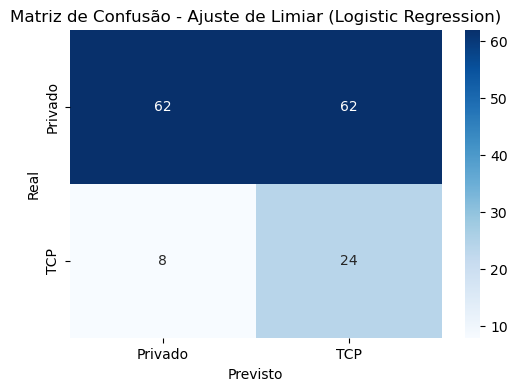

In [32]:
# Treine o modelo
best_model_m1.fit(x_train, y_train)

# Calcular probabilidades e encontrar o melhor limiar baseado no F1 Score
y_prob_train = best_model_m1.predict_proba(x_train)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_prob_train)

best_threshold, best_f1 = max(((threshold, f1_score(y_train, (y_prob_train >= threshold).astype(int))) for threshold in thresholds), key=lambda x: x[1])

print(f"Melhor limiar: {best_threshold} com F1 Score: {best_f1}")

# Ajustar previsões no conjunto de teste
y_pred_adjusted = (best_model_m1.predict_proba(X=x_test)[:, 1] >= best_threshold).astype(int)

# Matriz de Confusão
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)

# Exibição da Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Privado', 'TCP'], yticklabels=['Privado', 'TCP'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - Ajuste de Limiar ({best_model_name})')
plt.show()

In [25]:
print("ROC AUC: ", roc_auc_score(y_test, y_pred_adjusted))
print("Precision: ", precision_score(y_test, y_pred_adjusted))
print("Accuracy: ", accuracy_score(y_test, y_pred_adjusted))
print("Recall: ", recall_score(y_test, y_pred_adjusted))
print("F1 Score: ", f1_score(y_test, y_pred_adjusted))

ROC AUC:  0.6129032258064516
Precision:  0.2696629213483146
Accuracy:  0.532051282051282
Recall:  0.75
F1 Score:  0.39669421487603307
